# Introduction
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise, we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

## References
- https://rpubs.com/alanyang0924/TTE

## Data Preparation
This section loads the observational dataset, performs necessary preprocessing, and prepares it for target trial emulation (TTE). We check for missing values, rename columns, and ensure correct formatting.

### Per-Protocol and ITT Definitions
We define two datasets: Per-Protocol (PP) and Intention-to-Treat (ITT). These are fundamental to understanding different estimand strategies in causal inference. ITT keeps all patients in their originally assigned treatment groups, while PP considers only those who adhere to treatment.

In [68]:
import pandas as pd

# Load the dataset
data = pd.read_csv("../data/data_censored.csv")

print("\n📌 First few rows:")
print(data.head())

print("\n📌 Summary Statistics:")
print(data.describe())


📌 First few rows:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

📌 Summary Statistics:
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.499293    0.491331    0.997552    0.500173   
min      

### Preparing Estimands
Both `trial_pp` and `trial_itt` contain the same dataset but could later be processed differently based on the analysis approach.

We separate the estimand variables (Per-Protocol and Intention-to-Treat) because they represent different ways of analyzing the data and answering causal questions in a Target Trial Emulation (TTE). Each estimand helps address different types of biases and provides different perspectives on treatment effectiveness.

- ITT gives a "real-world" estimate of treatment effects with adherence variability.
    - It includes all participants in the treatment group they were originally assigned to, regardless of whether they actually received or adhered to the treatment.
- PP gives a "best-case scenario" estimate assuming perfect adherence.
    - It excludes patients who switched, discontinued, or otherwise deviated from the protocol.

In [69]:
# Define Per-Protocol (PP) dataset
trial_pp = {
    "data": data,
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

# Define Intention-to-Treat (ITT) dataset
trial_itt = {
    "data": data,
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

print("\n📌 PP:")
print(trial_pp['data'].head())

print("\n📌 ITT:")
print(trial_itt['data'].head())


📌 PP:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

📌 ITT:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872  

## Calculating Weight Models and Censoring

To handle informative censoring, we estimate inverse probability of censoring weights (IPCW). This involves fitting logistic regression models for different censoring mechanisms and treatment switches, allowing us to adjust for biases in survival analysis.

In Target Trial Emulation (TTE), we use Inverse Probability Weights (IPW) to adjust for biases introduced by:

1. Treatment Switching: Some patients may switch treatments during follow-up, which can bias the estimated effect of treatment.
2. Informative Censoring: If patients drop out or become censored based on factors related to their health, it can lead to biased survival estimates.

To correct for these biases, we estimate two types of weights:
- Treatment Switching Weights: Adjust for deviations from the assigned treatment.
- Inverse Probability of Censoring Weights (IPCW): Adjust for missing outcome data due to informative censoring.

In [70]:
# Import the libraries we'll use
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import joblib
import os

# Create directory to store models
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

def save_model(model, name):
    """Save the logistic regression model to disk."""
    path = os.path.join(MODEL_DIR, f"{name}.pkl")
    joblib.dump(model, path)
    return path

def calculate_weights(data):
    """Fits logistic regression models for weights and saves them."""
    models = {}

    # Rename "censored" to "censor_event" if needed
    if "censor_event" not in data.columns and "censored" in data.columns:
        data = data.rename(columns={"censored": "censor_event"})

    # Ensure "prev_treatment" exists
    if "prev_treatment" not in data.columns:
        data["prev_treatment"] = data["treatment"].shift(1).fillna(0)

    # Numerator model: P(censor_event = 0 | X)
    models["n"] = {
        "model": smf.logit("censor_event ~ x2", data=data).fit(),
        "path": save_model(smf.logit("censor_event ~ x2", data=data).fit(), "model_n")
    }

    # Denominator models (by previous treatment status)
    models["d0"] = {
        "model": smf.logit("censor_event ~ x2 + x1", data=data[data["prev_treatment"] == 0]).fit(),
        "path": save_model(smf.logit("censor_event ~ x2 + x1", data=data[data["prev_treatment"] == 0]).fit(), "model_d0")
    }

    models["d1"] = {
        "model": smf.logit("censor_event ~ x2 + x1", data=data[data["prev_treatment"] == 1]).fit(),
        "path": save_model(smf.logit("censor_event ~ x2 + x1", data=data[data["prev_treatment"] == 1]).fit(), "model_d1")
    }

    return models

# Compute weights for PP and ITT datasets
trial_pp_models = calculate_weights(trial_pp["data"])
trial_itt_models = calculate_weights(trial_itt["data"])

# Save weights in the dataset for further analysis
trial_pp["data"]["ipcw"] = trial_pp_models["n"]["model"].predict(trial_pp["data"])
trial_itt["data"]["ipcw"] = trial_itt_models["n"]["model"].predict(trial_itt["data"])

print("✅ Weights successfully computed and stored.")

# Print model summaries
for key, model_data in trial_pp_models.items():
    print(f"\n[{key}] Model Summary:\n", model_data["model"].summary())

Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.235254
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.235254
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287706
  

### Display Weight Models

In [71]:
def show_weight_models(models, name=""):
    """Display weight model summaries in a structured format."""
    print(f"\n📌 Weight Models for {name}")
    print("-" * 40)

    for key, model_data in models.items():
        print(f"\n[{key}] Model: P(censor_event = 0 | X)")
        print(model_data["model"].summary())  # Corrected access to model
        print(f"📁 Model saved at: {model_data['path']}")  # Corrected access to path

# Display weight summaries
show_weight_models(trial_pp_models, "Per-Protocol (PP)")
show_weight_models(trial_itt_models, "Intention-to-Treat (ITT)")



📌 Weight Models for Per-Protocol (PP)
----------------------------------------

[n] Model: P(censor_event = 0 | X)
                           Logit Regression Results                           
Dep. Variable:           censor_event   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        13:09:48   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4481      0.141    -17.415      0.000      -2.724      -2.173
x2             

### Treatment Switching Model (PP Only)
We'll first adjust for biases introduced by patients switching treatments mid-study by doing the following:
1. Split Dataset by Previous Treatment Status
    - We need separate models for patients who were already receiving treatment and those who were not in the previous period.
2. Fit Logistic Regression Models
    - This estimates the probability of continuing treatment only based on age.
    - This etimates probability of treatment based on age, x1, and x3 to account for additional confounders.
3. Compute Stabilized Weights
    - The stabilized weight corrects for bias introduced by treatment switching.

In [72]:
data_pp = trial_pp["data"]

# 1️⃣ Identify patients based on treatment status in the previous period
treated = data_pp[data_pp['treatment'].shift(1) == 1]
untreated = data_pp[data_pp['treatment'].shift(1) == 0]

# 2️⃣ Fitting numerator & denominator logistic regression models
numerator_model_treated = smf.logit("treatment ~ age", data=treated).fit()
numerator_model_untreated = smf.logit("treatment ~ age", data=untreated).fit()
denominator_model_treated = smf.logit("treatment ~ age + x1 + x3", data=treated).fit()
denominator_model_untreated = smf.logit("treatment ~ age + x1 + x3", data=untreated).fit()

# 3️⃣ Identify patients based on treatment status in the previous period
data_pp.loc[treated.index, 'num_prob'] = numerator_model_treated.predict(treated)
data_pp.loc[untreated.index, 'num_prob'] = numerator_model_untreated.predict(untreated)

data_pp.loc[treated.index, 'den_prob'] = denominator_model_treated.predict(treated)
data_pp.loc[untreated.index, 'den_prob'] = denominator_model_untreated.predict(untreated)

# Compute stabilized weights
data_pp['switch_weight'] = data_pp['num_prob'] / data_pp['den_prob']

Optimization terminated successfully.
         Current function value: 0.658108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590350
         Iterations 5


### Marginal Structural Model (MSM)
Marginal Structural Models (MSM) are used to estimate causal treatment effects while adjusting for time-dependent confounding. Here, we fit an MSM to model survival probability across different treatment strategies.

In [73]:
import statsmodels.api as sm

def fit_msm(data):
    """Fits a weighted Marginal Structural Model (MSM) using IPCW weights."""
    X = data[["treatment"]]  # Treatment as predictor
    X = sm.add_constant(X)  # Add intercept
    y = data["outcome"]  # Outcome variable
    weights = data["ipcw"]  # Inverse Probability of Censoring Weights (IPCW)

    msm = sm.WLS(y, X, weights=weights).fit()
    return msm

# Fit MSM for Per-Protocol and ITT datasets
msm_pp = fit_msm(trial_pp["data"])
msm_itt = fit_msm(trial_itt["data"])

# Print MSM Results
print("\n📌 MSM Results (Per-Protocol):\n", msm_pp.summary())
print("\n📌 MSM Results (ITT):\n", msm_itt.summary())



📌 MSM Results (Per-Protocol):
                             WLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.514
Date:                Sat, 08 Mar 2025   Prob (F-statistic):              0.219
Time:                        13:09:49   Log-Likelihood:                 436.66
No. Observations:                 725   AIC:                            -869.3
Df Residuals:                     723   BIC:                            -860.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.022

### Informative Censoring Model (For Both PP & ITT)
We now have to adjust for biases caused by patients dropping out for reasons related to their treatment/outcome by doing the following:
1. Fit Logistic Regression Models
    - The numerator model adjusts for x2, while the denominator model adjusts for x2 and x1, capturing more confounders.
2. Compute Inverse Probability of Censoring Weights (IPCW)
    - These weights correct for informative censoring, ensuring we correctly account for patients dropping out.

In [74]:
# 1️⃣ Fit numerator (1 - censored ~ x2) & denominator (1 - censored ~ x2 + x1) models 
numerator_censor_model = smf.logit("censored ~ x2", data=data_pp).fit()
denominator_censor_model = smf.logit("censored ~ x2 + x1", data=data_pp).fit()

# 2️⃣ Predict probabilities & computed stabilized weights
data_pp['num_censor_prob'] = numerator_censor_model.predict(data_pp)
data_pp['den_censor_prob'] = denominator_censor_model.predict(data_pp)

data_pp['censor_weight'] = data_pp['num_censor_prob'] / data_pp['den_censor_prob']

# 💾 Save the dataset with weights
data_pp.to_csv("../data/data_with_weights.csv", index=False)


Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7


### Visualizing Weight Distributions
After computing weights, we visualize their distributions using histograms. This helps us assess whether the estimated weights are stable or contain extreme values that may introduce bias in later steps.

#### Treatment Switching Weights
- The weights are mostly centered around 1, with values ranging from 0.76 to 1.56.
- The histogram shows some discrete peaks, possibly due to categorical covariates affecting the model.
- The mean is 1.03, and standard deviation is 0.19, suggesting moderate variation in switching weights.
- There are no extreme outliers, but the clustering around specific values might indicate that some patients have a higher probability of treatment switching than others.
#### Censoring Weights (IPCW)
- The distribution is more bimodal, with a large spike around 0.8 and another around 1.5-1.6.
- The mean is 1.10, with a higher standard deviation of 0.36 compared to switching weights.
- The first peak suggests that many patients have low censoring probability (near 0.8), while another group has higher censoring probability (~1.5-1.6).
- This could indicate informative censoring, where certain groups of patients have a higher probability of being censored.
#### Summary Statistics Review
- The quartiles confirm the observed distributions:
- Switching weights: Median ~1.01, with most values between 0.88 and 1.11.
- Censoring weights: Median ~0.81, but a wider spread (0.80 - 1.52).
- The censoring weights show more variability, which might affect the stability of the model.

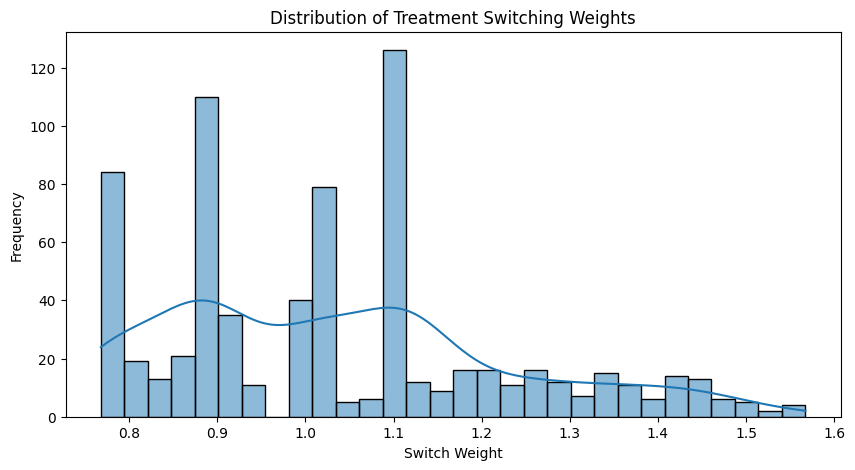

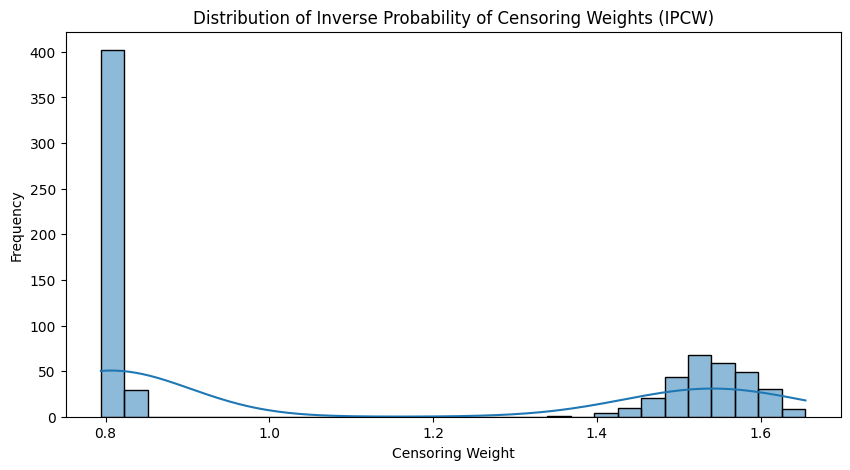

Switch Weight Summary:
 count    724.000000
mean       1.034929
std        0.192913
min        0.767832
25%        0.882456
50%        1.013526
75%        1.111745
max        1.567475
Name: switch_weight, dtype: float64

Censoring Weight Summary:
 count    725.000000
mean       1.103629
std        0.361864
min        0.794212
25%        0.802395
50%        0.815832
75%        1.526038
max        1.654696
Name: censor_weight, dtype: float64


In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.histplot(data_pp['switch_weight'].dropna(), bins=30, kde=True)
plt.title("Distribution of Treatment Switching Weights")
plt.xlabel("Switch Weight")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data_pp['censor_weight'].dropna(), bins=30, kde=True)
plt.title("Distribution of Inverse Probability of Censoring Weights (IPCW)")
plt.xlabel("Censoring Weight")
plt.ylabel("Frequency")
plt.show()

print("Switch Weight Summary:\n", data_pp['switch_weight'].describe())
print("\nCensoring Weight Summary:\n", data_pp['censor_weight'].describe())


## Specifying the Outcome Model
First, we define the outcome model and specify any adjustment terms. In the RPubs example, x2 is used as an adjustment variable in the intention-to-treat (ITT) analysis.

In [76]:
import statsmodels.formula.api as smf

# Extract data
trial_pp_data = trial_pp["data"]
trial_itt_data = trial_itt["data"]

# Ensure assigned_treatment exists
if "assigned_treatment" not in trial_pp_data.columns:
    trial_pp_data["assigned_treatment"] = trial_pp_data["treatment"]

if "assigned_treatment" not in trial_itt_data.columns:
    trial_itt_data["assigned_treatment"] = trial_itt_data["treatment"]

# Define the outcome model for per-protocol (PP) - Removing trial_period
formula_pp = "outcome ~ assigned_treatment + period + I(period**2)"
outcome_model_pp = smf.logit(formula_pp, data=trial_pp_data).fit()

# Define the outcome model for intention-to-treat (ITT) with adjustment terms - Removing trial_period
formula_itt = "outcome ~ assigned_treatment + x2 + period + I(period**2)"
outcome_model_itt = smf.logit(formula_itt, data=trial_itt_data).fit()

# Print model summary
print(outcome_model_itt.summary())


Optimization terminated successfully.
         Current function value: 0.076045
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075594
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  725
Model:                          Logit   Df Residuals:                      720
Method:                           MLE   Df Model:                            4
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.03828
Time:                        13:09:49   Log-Likelihood:                -54.806
converged:                       True   LL-Null:                       -56.987
Covariance Type:            nonrobust   LLR p-value:                    0.3592
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

## Expanding the Target Trials

We'll generate expanded trial data by:

- Creating copies of patient records for multiple time periods.
- Assigning a trial_period to each observation.

In [77]:
import pandas as pd
import numpy as np

def expand_trials(data, max_period=10):
    """
    Expands trial data by creating a sequence of target trials.
    Each patient gets multiple rows for different trial periods.
    """
    expanded_data = []
    
    for _, row in data.iterrows():
        for t in range(max_period + 1):  # Simulating follow-up time
            new_row = row.copy()
            new_row["trial_period"] = t
            new_row["followup_time"] = t  # Simulated follow-up time
            expanded_data.append(new_row)

    return pd.DataFrame(expanded_data)

# Expand both PP and ITT datasets
trial_pp_expanded = expand_trials(trial_pp_data, max_period=10)
trial_itt_expanded = expand_trials(trial_itt_data, max_period=10)

# Check expansion
print(trial_pp_expanded.head())


    id  period  treatment   x1        x2   x3        x4   age     age_s  \
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   

   outcome  ...      ipcw  num_prob  den_prob  switch_weight  num_censor_prob  \
0      0.0  ...  0.126322       NaN       NaN            NaN         0.126322   
0      0.0  ...  0.126322       NaN       NaN            NaN         0.126322   
0      0.0  ...  0.126322       NaN       NaN            NaN         0.126322   
0      0.0  ...  0.126322       NaN       NaN            NaN         0.126322   
0      0.0  ...  0.126322       NaN       NaN            NaN         0.126322   

   den_censor_prob  censor_weight  assigned_treatment  trial_p

## Loading or Sampling from Expanded Data
For large datasets, it's necessary to sample from the expanded data to control memory usage. The RPubs example samples control patients with outcome == 0.

In [78]:
def sample_expanded_data(data, seed=1234, p_control=0.5):
    """
    Samples expanded data based on outcome = 0 probability.
    This reduces memory usage while keeping all outcome=1 observations.
    """
    np.random.seed(seed)
    
    control_sample = data[data["outcome"] == 0].sample(frac=p_control, random_state=seed)
    treated_sample = data[data["outcome"] == 1]  # Keep all treated patients
    
    return pd.concat([control_sample, treated_sample])

# Sample ITT dataset
trial_itt_sampled = sample_expanded_data(trial_itt_expanded, seed=1234, p_control=0.5)

# Check the sampled data
print(trial_itt_sampled.head())


       id  period  treatment   x1        x2   x3        x4   age     age_s  \
371  51.0     7.0        1.0  0.0  0.246389  1.0 -0.454847  43.0  0.666667   
492  61.0     0.0        1.0  1.0 -0.612332  1.0  0.795096  39.0  0.333333   
648  89.0     6.0        1.0  0.0 -0.087012  1.0  1.046255  51.0  1.333333   
443  57.0     2.0        0.0  0.0 -0.127294  1.0  0.142746  39.0  0.333333   
229  33.0    11.0        1.0  1.0 -1.271945  0.0  0.867731  40.0  0.416667   

     outcome  ...      ipcw  num_prob  den_prob  switch_weight  \
371      0.0  ...  0.088061  0.633515  0.625516       1.012788   
492      0.0  ...  0.061641  0.652217  0.749622       0.870061   
648      0.0  ...  0.076765  0.594929  0.591301       1.006135   
443      0.0  ...  0.075494  0.449954  0.353539       1.272715   
229      0.0  ...  0.046586  0.647583  0.700678       0.924223   

     num_censor_prob  den_censor_prob  censor_weight  assigned_treatment  \
371         0.088061         0.110081       0.799961      

## Fitting the Marginal Structural Model (MSM)

We now fit a Marginal Structural Model (MSM) using inverse probability weights to adjust for confounding.

In [79]:
import warnings
import statsmodels.formula.api as smf

# Suppress only ValueWarnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

def fit_msm(data, weight_cols=["switch_weight", "censor_weight"]):
    """
    Fits a logistic regression MSM using inverse probability weighting.
    """
    data = data.copy()
    data["w"] = data[weight_cols].product(axis=1)  # Compute final weights
    
    formula = "outcome ~ assigned_treatment + x2 + period + I(period**2)"
    msm_model = smf.logit(formula, data, freq_weights=data["w"]).fit()  # Use freq_weights to avoid warning
    
    return msm_model

# Fit MSM on ITT sampled data
msm_itt = fit_msm(trial_itt_sampled)

# Print model summary
print(msm_itt.summary())

# Re-enable warnings after fitting the model
warnings.resetwarnings()


Optimization terminated successfully.
         Current function value: 0.128745
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 4048
Model:                          Logit   Df Residuals:                     4043
Method:                           MLE   Df Model:                            4
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.04182
Time:                        13:09:57   Log-Likelihood:                -521.16
converged:                       True   LL-Null:                       -543.91
Covariance Type:            nonrobust   LLR p-value:                 3.135e-09
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.4347      0.233    -14.739      0.000      -3.891      -2.978
assig

## Inference (Survival Prediction)

Finally, we use the fitted model to estimate survival probabilities over time.

This graph shows the survival difference over time, with a **blue line** representing the estimate and a **pink shaded area** for the 95% confidence interval (CI).  

- The survival difference starts around **0.02**, peaks at **0.035–0.04** around 6–8 time units, and then declines.  
- The **CI widens at the peak**, indicating greater uncertainty when the survival difference is highest.  
- The overall trend suggests an **initial benefit that diminishes over time**, possibly due to treatment effects wearing off or other competing risks.  

This visualization helps understand how survival differences evolve, highlighting both their magnitude and uncertainty.

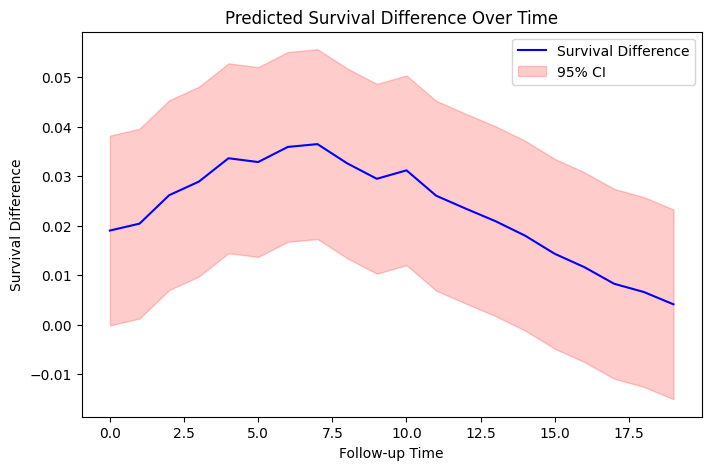

In [80]:
import matplotlib.pyplot as plt
import numpy as np

def predict_survival(model, data, times=np.arange(0, 11)):
    """
    Predicts survival probabilities for treatment groups over follow-up time.
    """
    # Generate predictions for each treatment group
    data_control = data.copy()
    data_control["assigned_treatment"] = 0  # Control group

    data_treated = data.copy()
    data_treated["assigned_treatment"] = 1  # Treated group

    preds_control = model.predict(data_control)
    preds_treated = model.predict(data_treated)

    # Compute survival probabilities (1 - predicted risk)
    survival_control = 1 - preds_control.groupby(data_control["period"]).mean()
    survival_treated = 1 - preds_treated.groupby(data_treated["period"]).mean()

    # Compute survival difference
    survival_diff = survival_treated - survival_control

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(survival_diff.index, survival_diff, label="Survival Difference", color="blue")
    plt.fill_between(survival_diff.index, survival_diff - 1.96 * np.std(survival_diff), 
                                       survival_diff + 1.96 * np.std(survival_diff), 
                                       color="red", alpha=0.2, label="95% CI")

    plt.xlabel("Follow-up Time")
    plt.ylabel("Survival Difference")
    plt.title("Predicted Survival Difference Over Time")
    plt.legend()
    plt.show()

# Apply prediction
predict_survival(msm_itt, trial_itt_sampled)
